<a href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/notebooks/ICAPS_SummerSchool_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Motion Planning

In our previous [tutorial](https://colab.research.google.com/drive/1ZRp8WMJNjKbUFQuKF5Yjzuu-yTu8GTtW?usp=sharing), we explored various aspects of task planning, which we used to refer to the high-level decision-making that determines a sequence of actions that should be executed to achieve a goal state.

Concretely:

1. We introduced the N-table Blocks World (NTBW) domain, which extends the classical Blocks World domain by including several tables instead of a single surface, and tried to capture some of the complexities that arise when considering real robots.
2. We presented a pddl representation of the NTBW domain, and discussed some of the limitations of what an abstract task planning domain can capture.
3. We used various task planning methods, all instances of best first search, to solve the pddl formulation of NTBW (and if you had time - you also used q-learning).

All this is important and non-trivial, but we hopefully understand by now that if we want to use planning in a real-world robotic setting, high-level planning is not enough: we need a way to translate high-level actions into low-level feasible motions.

In this tutorial, we will focus on **motion planning**, which deals with the low-level details of generating feasible motions that achieve the specified objectives safely and efficiently. For this, we will peel back some of the abstractions previously applied to our MTBW domain. By doing this, we aim to expose the underlying challenges that emerge and that need to be addressed when translating high-level plans to low-level motions and to understand some of the methodologies that can be used to address these challenges in real-world robotic settings.



It is important to note that, as we will see later on, even after we have both motion planning and task planning figured out, that does not mean we will be done. Another important aspect is that in the real world, things might fail in various ways, so we can't simply send commands and assume they will be executed. We need a way to monitor the execution of our actions and provide feedback on whether a high-level action was successfully performed. Also, if an action fails, we need to find the best way to recover. We will not cover all this in this tutorial, but it is important to keep this in mind as we start understanding the complexities of motion planning.

# Setup

In [1]:
!pip install "git+https://github.com/CLAIR-LAB-TECHNION/ICAPS-24"

  Cloning https://github.com/CLAIR-LAB-TECHNION/ICAPS-24 to /tmp/pip-req-build-docp28o9
  Running command git clone --filter=blob:none --quiet https://github.com/CLAIR-LAB-TECHNION/ICAPS-24 /tmp/pip-req-build-docp28o9
  Resolved https://github.com/CLAIR-LAB-TECHNION/ICAPS-24 to commit 4ea4a8fa8facbd4dae884b0b0d146fd7de69eef6
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/CLAIR-LAB-TECHNION/aidm to /tmp/pip-install-g6vunx5l/aidm_822459b0d9ed478c825b719a24dd950f
  Running command git clone --filter=blob:none --quiet https://github.com/CLAIR-LAB-TECHNION/aidm /tmp/pip-install-g6vunx5l/aidm_822459b0d9ed478c825b719a24dd950f
  Resolved https://github.com/CLAIR-LAB-TECHNION/aidm to commit 5f94350498f71074944a227b976bbfc1139ecef2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/

## Installations and imports

In [2]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [3]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

In [4]:
import mediapy as media
import numpy as np
from numpy import pi

# Introduction to continuous N Table Blocks World (NTBW)


Up until now, we have treated actions in the NTBW domain, such as 'pick up block x' or 'put down block x on table y' as atomic operations. However, in real-life applications, a robot must physically move to a block's position to execute these actions. This movement needs to be as precise as possible, efficient, safe, and free from collisions.
Moreover, actual movement occurs in the physical world where states are no longer merely discrete symbols, but are rather represented using continuous variables.


In NTBW, the state includes a continuous variable representing the positions of blocks and the joint angles of the robot, requiring a more complex and accurate state representation to be used by the motion planning and execution components.

We begin by introducing our continuous NTBW domain and by examining how a state is represented in this environment.


In [5]:
from n_table_blocks_world.n_table_blocks_world import NTableBlocksWorld
env = NTableBlocksWorld(render_mode="rgb_array")
state = env.reset()
print(state.keys())

dict_keys(['robot_joint_pos', 'robot_joint_velocities', 'gripper_state_closed', 'object_positions', 'grasped_object', 'geom_contact'])


In this simulation, similar to real-world conditions, we operate within a continuous space. The state of the system includes the positions of blocks in three-dimensional space, the states of the robot's joints, the state of the gripper, the grasped object, and geometry contact information.
Let's see how all of them look (except for the last one, which we will talk about in the next lab).

In [6]:
_ = state.pop('geom_contact', None)
for key, value in state.items():
    print(key, ":", value)
    print()

robot_joint_pos : [-1.57077736e+00 -1.57060980e+00  1.57108304e+00 -1.57073077e+00
 -1.57080018e+00  2.94072227e-09]

robot_joint_velocities : [ 2.13547184e-03  2.84822042e-02  3.46920757e-02  9.73483683e-03
  1.11585800e-05 -1.85546721e-07]

gripper_state_closed : False

object_positions : {'block 1': array([-0.1       ,  0.55      ,  0.72986352]), 'block 2': array([0.1       , 0.5       , 0.72986352]), 'block 3': array([0.2       , 0.63      , 0.72986352]), 'block 4': array([0.24      , 0.39      , 0.72986352]), 'block 5': array([-0.2       , -0.52      ,  0.72986352]), 'block 6': array([ 0.1       , -0.51      ,  0.72986352]), 'block 7': array([-0.07      , -0.65      ,  0.72986352]), 'block 8': array([-0.1       , -0.4       ,  0.72986352]), 'block 9': array([6.00000000e-01, 3.55271368e-20, 7.29761806e-01]), 'block 10': array([ 6.00000000e-01, -6.66133815e-21,  7.60335562e-01])}

grasped_object : None



## Workspace and Configuration Space

Two important concepts we need to know to better understand the state representation are the **workspace** and **configuration space**.


In the context of robotics, the workspace refers to the physical space in which a robot operates. This includes all the points in the robot's reach or the volume within which the end-effector or any part of the robot can move.


Configuration space, often abbreviated as C-space, represents all possible states or configurations of a robot, where each point in this space corresponds to a unique position and orientation of the robot. In C-space, obstacles are represented as regions that the robot's configuration cannot occupy.

The configuration space is multi-dimensional, depending on the number of **degrees of freedom (DOF)** of the robot, typically reprsenting its controllable joints. Thus, a **configuration** corresponds to a unique position and orientation of the robot.  



The image below, taken from MODERN ROBOTICS MECHANICS, PLANNING, AND CONTROL
Kevin M. Lynch and Frank C. Park https://hades.mech.northwestern.edu/images/7/7f/MR.pdf, demonstrates the idea of a configuration space of 3 different items.  


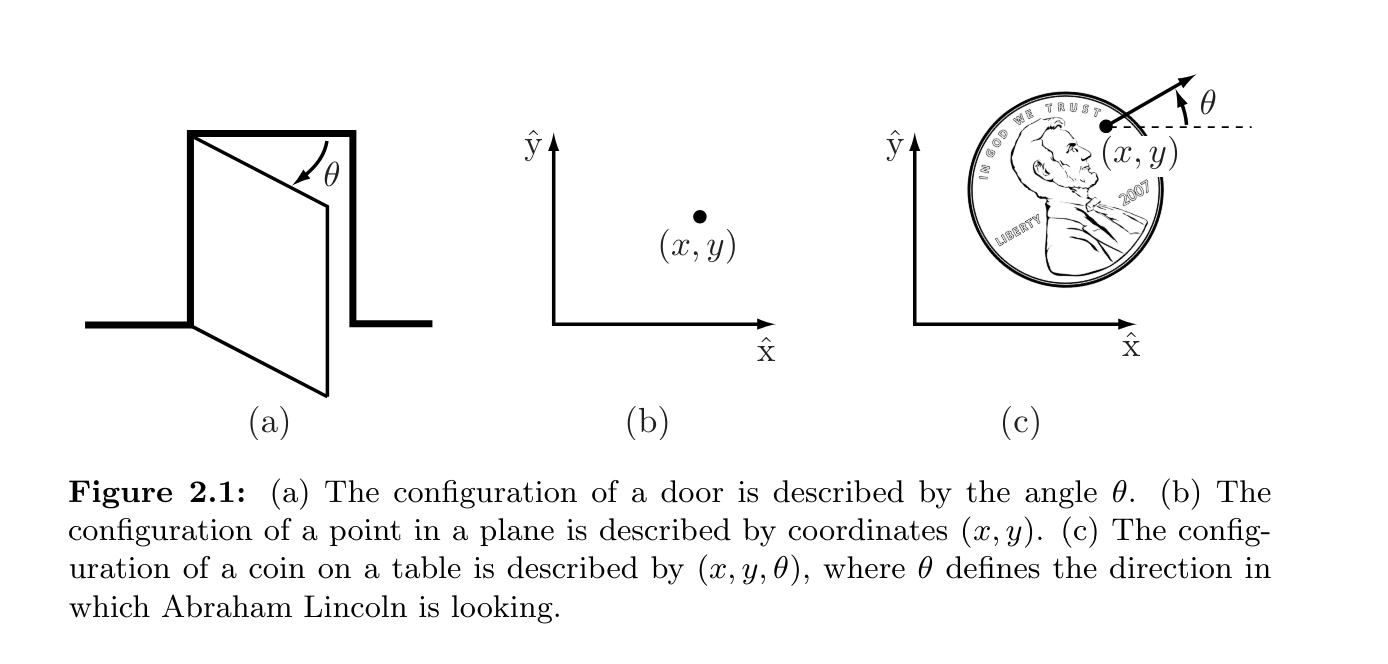





If you want to undestand this idea better, use this [link](https://www.cs.unc.edu/~jeffi/c-space/robot.xhtml). This easy-to-use online app, created by Prof. Ron Alterovitz's from UNC, will allow you to play around with a robotic arm with 2 DOF and see the mapping between workspace and C-Space.  

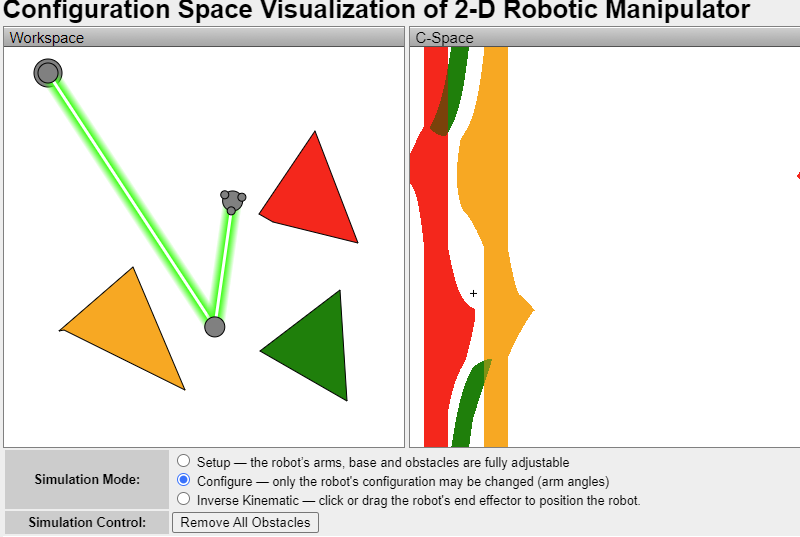

In summary, while the workspace is concerned with the physical limits of where a robot can operate, the configuration space deals with the abstract, mathematical representation of all possible states of the robot, crucial for path planning and avoiding collisions.

For our robotic arm, the workspace would be the volume of space around the base within which the arm can position its end-effector.

It's configuration space space has $6$ DOFs for each of its joints.


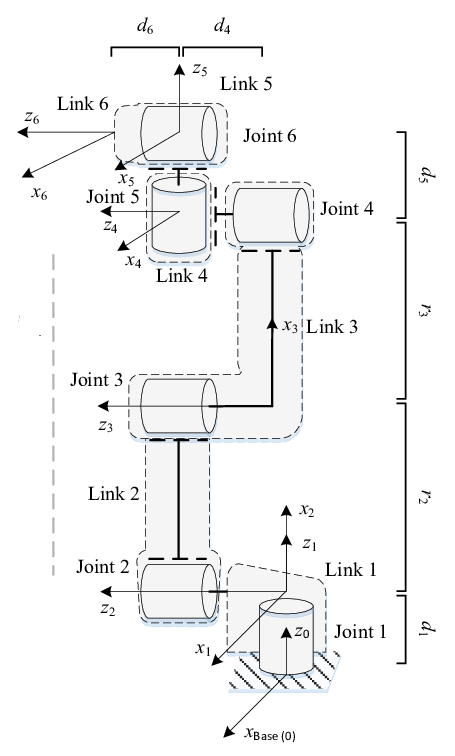

 Let's examine an image rendered from this environment to better visualize these elements.

""

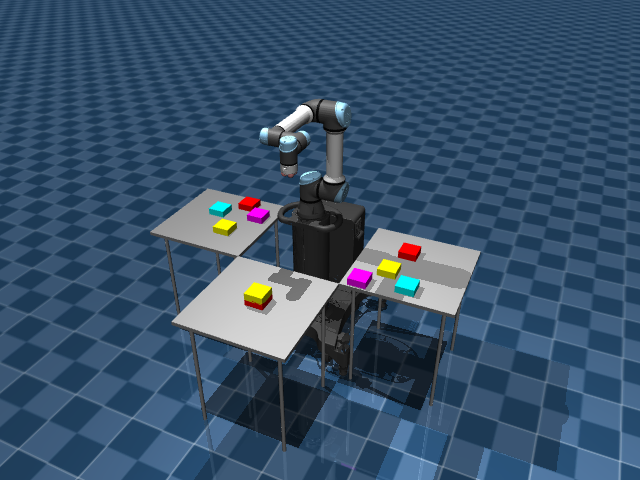

In [7]:
im = env.render()
media.show_image(im)

# Actions in Our Simulated Setting

In our simulated environment, actions consist of position control commands to the robot, specifying the desired configuration, i.e., the desired joint angles. The robot's actuators exert forces proportional to the difference between the target configuration (specified by the joint angles) and the current configuration. If we maintain the same target position across multiple simulation steps, the robot will gradually approach and stabilize near that position.

To achieve this, the robot relies on underlying controllers that manage the forces applied to reach the desired configuration. Typically, these controllers are PID (Proportional, Integral, and Derivative) controllers or controllers that employ more advanced methods such as feed-forward control. These controllers add another level of abstraction, and in some cases, integrating them with task and motion planning can be beneficial. However, we will not delve into these integration scenarios in this lab.

By understanding these control mechanisms, we can appreciate the complexities involved in precise robot movements and the importance of accurate position control in executing tasks.

**Note the difference from the way we used actions in task planning as instantaneous! Here, we need to make sure to apply the action for enough time to make sure the target configuration is reached!**

 Let's move the robot between different configurations and record a video of its movements to observe this behavior in action.

In [8]:
number_of_steps = 100

In [9]:
framerate = 60
frames = []

state = env.reset()

# move to all joints at -45 degrees, for number_of_steps steps:
action = [-pi/4]*6
for i in range(number_of_steps):
    state = env.step(action)
    frames.append(env.render())

# move to another config for number_of_steps steps:
action = [0, -pi/2, pi/2, 0, 0, 0]
for i in range(number_of_steps):
    state = env.step(action)
    frames.append(env.render())

# show video:
media.show_video(frames, fps=framerate)

Note that the last cell took a while to run, primarily because the env.render() call, which generates images from the environment, is time-consuming. To reduce runtime, from now on, let's render the environment only every 8 steps instead of after every single step. The videos will look a bit choppier, but we can adjust this setting whenever we need smoother, better-looking videos.

⚒ **Task 1**: Try setting different values to number_of_steps and rerun the code to see what happens.



Below, we implement a convenience function that moves the robot to a desired configuration. This function eliminates the need to rewrite the control loop each time. It is designed to automatically stop when the robot reaches the desired configuration and when the joint velocities are sufficiently low. Additionally, this method generates frames for a video at a specified frequency, allowing for flexible visualization of the robot's movement.

In [ ]:
def move_to(env, target_config, tolerance=0.05, end_vel=0.1, max_steps=None,
            render_freq=8):
    '''
    move robot joints to target config, until it is close within tolerance,
    or max_steps exceeded.
    @param target_joint_pos: position to move to
    @param tolerance: distance withing configuration space to target to consider
     as reached
    @param max_steps: maximum steps to take before stopping, no limit if None
    @param render_freq: how often to render and append a frame
    @return: success, frames
    '''
    joint_positions = env.robot_joint_pos
    joint_velocities = env.robot_joint_velocities

    frames = []

    i = 0
    while np.linalg.norm(joint_positions - target_config) > tolerance \
    or np.linalg.norm(joint_velocities) > end_vel:
        if max_steps is not None and i > max_steps:
            return False, frames

        state = env.step(target_config)
        joint_positions = state['robot_joint_pos']
        joint_velocities = state['robot_joint_velocities']

        if i % render_freq == 0:
            frames.append(env.render())

        i += 1

    return True, frames

And let's test it:

In [ ]:
framerate = 8
render_freq = 8

env.reset()

config1 = [-pi/4]*6
success, frames1 = move_to(env, config1)

config2 = [0, -pi/2, pi/2, 0, 0, 0]
success, frames2 = move_to(env, config2)

frames = np.concatenate([frames1, frames2])

# show video:
media.show_video(frames, fps=framerate)

⚒ **Task 2**:
Recall that our task is to pick up and move the blocks.
Try to move the end effector of the robotic arm to be above the yellow block that is on the right table while the end effector is facing downwards.
Complete the code in the following cell.
Give it 3-5 attempts to get as close as you can (you can find a proposed solution below).

In [ ]:
# choose a config that will bring the end effector to be above the yellow
# block that is on the right table. This configuration will be used as an action
above_right_yellow_block = # TODO - your code here

success, frames = move_to(env, above_right_yellow_block)
media.show_video(frames, fps=framerate)

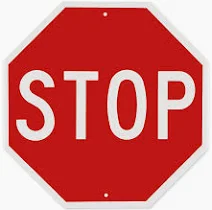

Below we give a possible solution. Don't let us spoil your fun.


In [10]:
# proposed solution:
above_right_yellow_block = [-0.6, -0.6, 1.7, 0.7, pi/2, 0]

success, frames = move_to(env, above_right_yellow_block)
media.show_video(frames, fps=framerate)

NameError: name 'move_to' is not defined

# Forward and Inverse Kinematics

In the previous task, we aimed to position the end effector of the robot directly above the yellow block. The robot is controlled in configuration space, which involves specifying joint angles. However, our objective is to place the end effector at specific coordinates and orientation within the workspace—the physical space where the robot interacts with objects. This task requires converting our workspace goal (position and orientation of the end effector) into the appropriate joint configurations in the configuration space.

![forward and inverse kinematic](https://github.com/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/assets/figures/f_inv_kinematics.png?raw=true)

The process of mapping from a robot's configuration—specifically its joint angles—to the workspace—where the end effector's position and orientation are defined—is known as **forward kinematics**. This mapping is indeed feasible and relatively intuitive if we know the robot's geometric parameters, such as the lengths and relative positions of its links. The computation of the end effector's pose from the joint configurations is typically represented using matrix multiplications. These matrices, often referred to as transformation matrices, sequentially transform the pose from one joint to the next along the robot's arm, ultimately resulting in the pose of the end effector in the workspace.

**Inverse kinematics (IK)** involves determining the joint configurations that will achieve a specified position and orientation of the end effector in the workspace. This process is the reverse of forward kinematics and can be more complex because there may be multiple, or even an infinite number of, joint configurations that can result in the same end effector pose. IK essentially frames this challenge as an optimization problem, where the goal is to find the best set of joint angles that satisfy the end effector's target position and orientation. Unlike the direct calculations used in forward kinematics, solving inverse kinematics often requires the use of numerical methods and optimization techniques to find feasible solutions.

In this lab, we won't delve into the detailed mathematical formulations typically required to solve inverse kinematics. Instead, we'll utilize an out-of-the-box implementation that simplifies this process. This approach allows us to focus more on the application and integration of inverse kinematics within our tasks, without getting caught up in the complexities of the underlying algorithms.

# PickUp in the real(alistic) world

Having explored the continuous space representation, we move on to demonstrate how an action, considered atomic in the task planning domain, is implemented in our robotic setting.

A first thing to consider if we want to pick up an object, is reaching a configuration from which it can be picked up.

If we want to pick up the yello block, we need to first extract the Cartesian coordinates of its position and set a target position for the robot's end effector to be 10 centimeters above the block. This height will allow the robot to grasp the block effectively.

In [ ]:
object_positions = state['object_positions']
target_position = object_positions['block 2']
target_position[2] += 0.1  # add 10 centimeters to Z axis
print("target position:", target_position)

We also need to specify the target orientation for the end effector. For picking up blocks, the end effector should be oriented downward. This target orientation can be provided as a rotation matrix, which will define the exact angular positioning required for the end effector to successfully engage with the blocks.

In [ ]:
facing_down_R = [[0, 0, -1],
                 [0, 1, 0],
                 [1, 0, 0]]

## `move-to-position` with inverse kinematics

To make things simpler, we provide a motion planning utility class that includes the implementation of inverse kinematics, among other useful methods that will be detailed later. Let's utilize this class to find an inverse kinematic solution where the end effector is oriented downwards and positioned directly above the yellow block.

In [ ]:
from motion_planning.motion_planner import NTableBlocksWorldMotionPlanner

motion_planner = NTableBlocksWorldMotionPlanner()
above_yellow_block_config = motion_planner.ik_solve(goal_pos=target_position,
                                                    goal_R=facing_down_R,)
print(above_yellow_block_config)


Let's test this solution:

In [ ]:
env.reset()
success, frames = move_to(env, above_yellow_block_config, max_steps=200)
media.show_video(frames, fps=framerate)

## Moving in Configuration Space

Now that we can easily find inverse kinematics solutions for pickup and drop-off positions, let's try to pick up the yellow block and place it above the purple block, which is on the left table. To do this, we:

1. Move above the yellow block (which we have already done).
2. Close the gripper* by calling env.set_gripper(True). This sets the gripper's state to closed, enabling it to grasp any nearby object.
3. Use inverse kinematics to compute the configuration above the purple block, similar to what we did before.
4. Open the gripper using env.set_gripper(False) to release the yellow block.



*here, we are using a suction gripper, for which close and open refer to creating and releasing suction using a vacuum system.

This process is quite straightforward. Nothing should go wrong, right?

⚒ **Task 3**:
complete the code cell where decribed below to perform what we discussed above.

In [ ]:
drop_position = object_positions['block 8']
drop_position[2] += 0.1
above_purple_block_config = motion_planner.ik_solve(goal_pos=drop_position,
                                                    goal_R=facing_down_R,)

env.set_gripper(True)
success, frames = ### complete here! use the move_to function ###
env.set_gripper(False)

media.show_video(frames, fps=framerate)


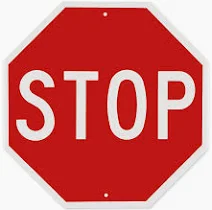

Below we give a possible solution. Don't let us spoil your fun.


In [ ]:
drop_position = object_positions['block 8']
drop_position[2] += 0.1
above_purple_block_config = motion_planner.ik_solve(goal_pos=drop_position,
                                                    goal_R=facing_down_R,)

env.set_gripper(True)
success, frames = move_to(env, above_purple_block_config, max_steps=100)
env.set_gripper(False)

media.show_video(frames, fps=framerate)


We successfully identified a valid inverse kinematic solution for the drop-off position and attempted to move to it from our pick-up configuration. However, during this transition, the robot collided with an obstacle (here, it's base). The issue arises because the robot, while moving in the configuration space, follows the shortest path, which corresponds to a straight line.


It's important to note that this 'straight line' in the configuration space does not translate to a straight line in the workspace. This discrepancy can lead to unexpected collisions because the path in the workspace might intersect with obstacles that are not accounted for in the configuration space. This incident underscores the importance of **motion planning**, which helps ensure that a robot's path is both collision-free and feasible within the physical workspace.

# Motion Planning


Before discussing motion planning in configuration space, let's examine how our motion planner models the workspace. Our motion planner uses a world model to plan collision-free paths. It samples robot configurations and utilizes this model to check for collisions. Let's take a look at a visualization of how the motion planner perceives the world.

In [ ]:
motion_planner.set_config(above_yellow_block_config)
motion_planner.visualize()

You can use the mouse to move the viewpoint, pressing Ctrl to translate and Shift to zoom in and out.

Note that this is a simplified representation of the world. For instance, the table legs are omitted, the robot mount is represented as a box, and the robot's 3D model is less detailed. This simplification enhances efficiency, as the motion planner must perform geometry computations to check for collisions every time it samples a configuration. A more complex 3D world model would increase the time required to check for collisions during pathfinding. With an exact model, such as the one used in our simulator, finding a path could take a minute instead of just a few seconds.

## Managing Objects in the Motion Planner
Note that there are no blocks in our motion planner world, thus it won't consider possible collision with them when planning. This may result a plan in which the robot collides with blocks which will move or drop them from the table. Let's add the blocks to the motion planner.

We have a method to add blocks with names. We will use the names that are given in the state.

In [ ]:
state = env.reset()
blocks_state = state['object_positions']
print(blocks_state)

In [ ]:
for name, pos in blocks_state.items():
    motion_planner.add_block(name, pos)

motion_planner.visualize()

Now the motion planner accounts for the blocks as well, but the positions of the blocks can change with each motion plan. To ensure the motion planner accurately reflects the current state of the world, we must update the position of each block whenever it moves. This can be done using the method move_block(name, pos).

Let's create a convenient function that updates the positions of all blocks based on the given state. Remember to call this function after every manipulation to maintain accuracy.

In [ ]:
def update_blocks_positions(motion_planner, blocks_positions_dict):
    for name, pos in blocks_positions_dict.items():
        motion_planner.move_block(name, pos)

When the robot grasps a block, it should consider that the block moves with the end effector for collision detection purposes. Essentially, the block becomes part of the robot. The methods below allow for attaching and detaching the block from the end effector for subsequent motion planning.

In [ ]:
motion_planner.attach_box_to_ee()
motion_planner.set_config([0, -pi/2, 0, 0, 0, 0])
motion_planner.visualize()

In [ ]:
motion_planner.detach_box_from_ee()
motion_planner.visualize()

## Sampling Based Motion Planning Algorithms
The configuration space, or C-space, represents all possible orientations and positions of a robot's joints. A crucial part of this space is the 'free space,' which consists of configurations that avoid any collisions with obstacles or the robot itself. Successfully identifying and navigating within this free space is essential for effective motion planning.


Representing the free space within the configuration space is a complex challenge due to the intricate geometry translated from the workspace into a high-dimensional space. Specifically, the configuration space is six-dimensional, corresponding to the robot's six joints. This complexity makes accurately modeling the exact geometry both difficult and computationally intensive. To manage this, we employ sampling methods that allow us to approximate which areas of the configuration space are free from collisions. By randomly sampling points across this six-dimensional space, we can efficiently identify (probably) feasible paths for the robot, bypassing the need for a complete and detailed representation of all possible configurations.


After determining which samples fall within the free space, the next step is to connect these points. We attempt to draw straight paths between neighboring points in the configuration space, consistently checking, via forward kinematics, that these paths do not intersect any obstacles in the workspace. This iterative process of checking and connecting points forms the backbone of constructing a viable path for the robot.

Collision detection is a major bottleneck in this process due to its computational demands. To enhance efficiency, we often use simplified geometric models of the robot and its environment. This reduction in complexity speeds up the collision checks without significantly compromising the accuracy of the path planning.

The figure below (taken from http://motion.cs.illinois.edu/RoboticSystems/figures/planning/prm.svg) illustrates a sampling-based motion planning algorithm applied within a 2D configuration space. This simplification helps visualize the concept more easily. however, it is crucial to remember that our robot operates within a 6D domain, making the actual problem significantly more complex.
![motion planning](http://motion.cs.illinois.edu/RoboticSystems/figures/planning/prm.svg)
Here's how the process unfolds in the figure:

* a. demonstrates how a single point is sampled. The motion planner must have the ability to check whether a point in configuration space is within collision or not. The point sampled in this example is within collision, thus it can't be part of a path
* b. we sample many points, and drop those that are not in the free space
* c. we add the start and goal points
* d. we try to connect each point to it's neighbors, and check if the line that connect them doesnt hit an obstacle
* e. a roadmap is built,
* f. we search for a path from start to goal along this roadmap.



The algorithm described is known as Probabilistic Road Map (PRM), which is effective for planning paths in a variety of environments by randomly sampling points and connecting them in a network. Another popular type of sampling-based motion planning algorithm is the Rapidly-exploring Random Tree (RRT).RRT works by incrementally building a tree that branches out from the starting point into the configuration space. It begins by randomly sampling a point and connecting it to the nearest existing node in the tree, provided the path between these points is free of obstacles. This process continues, rapidly expanding the tree until it reaches the vicinity of the goal state or covers a significant portion of the space. RRT is particularly favored for its ability to quickly find a feasible path, even in high-dimensional spaces, making it suitable for environments where obstacles are dense and planning must be done quickly.



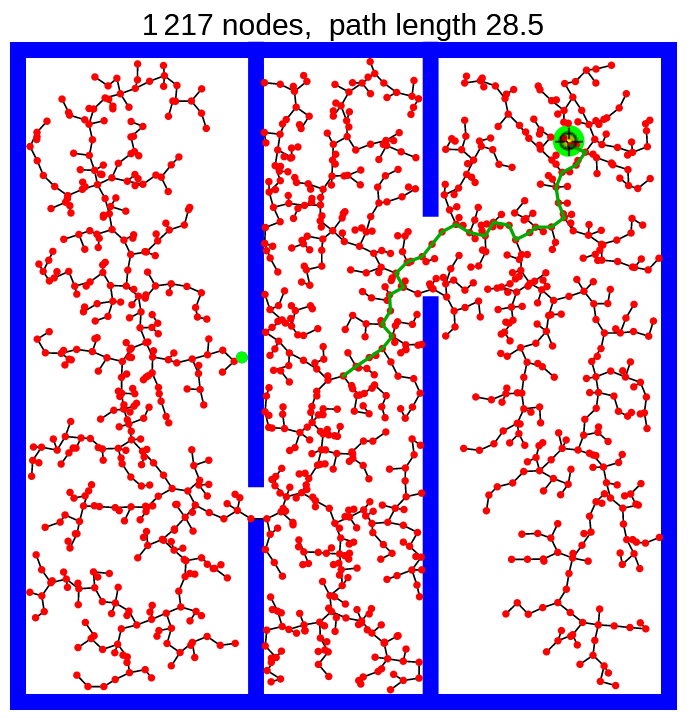

A search tree built by the RRT algorithm in a 2D configuration space.

Follow this [link](https://demonstrations.wolfram.com/RapidlyExploringRandomTreeRRTAndRRT/) to see RRTs in action. This demo was created by Aaron T. Becker and Li Huang.

Both PRM and RRT are foundational techniques in robotic motion planning, each with unique strengths making them suitable for different scenarios in robotics and automated systems.


## Finding a Path Using Our Motion Planner
Our motion planner employs the RRT* algorithm, an enhanced version of the original Rapidly-exploring Random Tree (RRT) algorithm. While we won't delve into the specifics of the RRT* implementation, we will make use of it directly as we have with the inverse kinematics computations.

Now let's see how to use our motion planner to find path. We can use *plan_from_config_to_pose* method to pass an initial robot configuration, and goal pose of the end effector. The output is a path, which is a list of configurations. The first configuration on the list is the start configuration, the last is the configuration where the end effector is at the desired pose, and the robot can move straight from each configuration to it's subsequent without collision (i.e., in a straight line in **configuration space**).

In [ ]:
path = motion_planner.plan_from_config_to_pose(
    start_config=above_yellow_block_config,
    goal_R=facing_down_R,
    goal_pos=drop_position,
    )


In [ ]:
print(path)

We can visualize the path as animation using the following method:

In [ ]:
motion_planner.visualize_path(path)

⚒ **Task 4**:
Use the motion planner to plan a path from a certein block position to another and visualize it. Try to play with it for a little bit. You can see what other arguments you can pass to the planning method, and you can see what other methods are implemented in it.
If you still have time, you can dive into the code:
https://github.com/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/motion_planning/motion_planner.py


In [ ]:
### your code here ###

In [ ]:
### play with the motion planner ###

In [ ]:
### use as much code cells as you want ###

## Path Execution
Once we have identified a path, which consists of waypoints in the configuration space, the next step is to execute it. This is achieved by sequentially moving through these waypoints in a loop, ensuring that the robot transitions from one waypoint to the next in order to complete the designated route.

In [ ]:
env.reset()
success, frames = move_to(env, above_yellow_block_config, max_steps=200)

env.set_gripper(True)
motion_planner.attach_box_to_ee()

frames_all = []
for p in path:
    success, frames = move_to(env, p, max_steps=200)
    frames_all.extend(frames)
media.show_video(frames_all, fps=framerate)

# Wrap Up
Now that we understand how to plan a path and execute it, let’s develop a helper function that consolidates these steps into a single movement command. First, we will create a path execution helper function. This function will not only move the robot along the planned path but also capture and save image frames of the movement sequence:


In [ ]:
def execute_path(env, path, tolerance=0.05, end_vel=0.1,
                 max_steps_per_section=200, render_freq=8):
    """
    execute a path of joint positions
    @param path: list of joint positions to follow
    @param tolerance: distance withing configuration space to target to consider as reached to each point
    @param end_vel: maximum velocity to consider as reached to each point
    @param max_steps_per_section: maximum steps to take before stopping at each section
    @param render_freq: how often to render and append a frame
    @return: success, frames
    """
    frames = []
    for config in path:
        success, frames_curr = move_to(env,
                                       config,
                                       tolerance=tolerance,
                                       end_vel=end_vel,
                                       max_steps=max_steps_per_section,
                                       render_freq=render_freq)
        frames.extend(frames_curr)
        if not success:
            return False, frames

    return True, frames

On top of our path execution function, we will implement an additional function that not only plans a path to a desired Cartesian goal but also executes it. This function will manage the full cycle of movement, from planning through execution. Importantly, it also updates the positions of blocks in the motion planner after each movement. This is crucial, as the positions of blocks may change following each robot interaction.

In [ ]:
def move_to_pose(env, motion_planner, target_position,
                 target_orientation=facing_down_R, tolerance=0.05,
                 end_vel=0.1, max_steps_per_section=400, render_freq=8):
    """
    move robot to target position and orientation, and update the motion planner
    with the new state of the blocks
    @param target_position: position to move to
    @param target_orientation: orientation to move to
    @param tolerance: distance withing configuration space to target to consider as reached
    @param max_steps_per_section: maximum steps to take before stopping a section
    @param render_freq: how often to render and append a frame
    @return: success, frames
    """
    joint_state = env.robot_joint_pos
    path = motion_planner.plan_from_config_to_pose(joint_state, target_position,
                                                   target_orientation)
    success, frames = execute_path(env,
                                   path,
                                   tolerance=tolerance,
                                   end_vel=end_vel,
                                   max_steps_per_section=max_steps_per_section,
                                   render_freq=render_freq)

    # after executing a motion, blocks position can change, update the motion planner:
    update_blocks_positions(motion_planner, env.get_state()['object_positions'])

    return success, frames

Often, our tasks require moving the end effector directly above a certain block, either to pick it up or to place another block on top of it. This involves accurately determining the block's position and then navigating the end effector to that specific location. To streamline this process, we can implement a dedicated helper function. This function will automatically handle these tasks by taking the name of the block as input, extracting its position, and using our previously implemented function to move the end effector to the desired position above the block.

In [ ]:
def move_above_block(env, motion_planner, block_name, offset=0.1,
                     tolerance=0.05, end_vel=0.1, max_steps_per_section=400,
                     render_freq=8):
    """
    move robot above a block
    @param block_name: name of the block to move above
    @param offset: how much above the block to move
    @param tolerance: distance withing configuration space to target to consider as reached
    @param max_steps_per_section: maximum steps to take before stopping a section
    @param render_freq: how often to render and append a frame
    @return: success, frames
    """
    block_pos = env.get_object_pos(block_name)
    target_position = block_pos + np.array([0, 0, offset])
    return move_to_pose(env, motion_planner, target_position,
                        tolerance=tolerance, end_vel=end_vel,
                        max_steps_per_section=max_steps_per_section,
                        render_freq=render_freq)

Now, let’s apply what we’ve learned to complete a small task. We aim to construct a tower with a cyan block on top of a purple block, which in turn rests on a yellow block at the front table. First, we’ll reset our environment to ensure a clean setup. Next, we'll select a position for the base of our tower. For the initial yellow block, we’ll choose a spot above the front table that is clear of any overlapping with other blocks. This positioning is crucial as it sets the foundation for the rest of our tower construction. We will talk about automating this choice in the next tutorial.

In [ ]:
state = env.reset()
init_config = state['robot_joint_pos']

state['object_positions']

In [ ]:
tower_position = [0.45, 0.15, 0.85]

Now, let's execute the sequence of actions required to perform this small task. It's important to note that success is not guaranteed on every attempt, for several reasons. The primary challenge is that our control method is not flawless, and the robot may not follow the planned path precisely. Ideally, after each movement, we should verify whether the action was successful and allow the task planner to decide the next steps in case of a failure.

In [ ]:
render_freq = 8
framerate = 8


# pick up yellow block from right table:
success, frames1 = move_above_block(env, motion_planner, 'block 2', render_freq=render_freq)
env.set_gripper(True)
motion_planner.attach_box_to_ee()

# drop at target position
success, frames2 = move_to_pose(env, motion_planner, tower_position,
                                render_freq=render_freq)
env.set_gripper(False)
motion_planner.detach_box_from_ee()


# Now pick up purpule block and put it above
success, frames3 = move_above_block(env, motion_planner, 'block 8', render_freq=render_freq)
env.set_gripper(True)
motion_planner.attach_box_to_ee()
success, frames4 = move_above_block(env, motion_planner, 'block 2', render_freq=render_freq)
env.set_gripper(False)
motion_planner.detach_box_from_ee()

# now stack another cyan block
success, frames5 = move_above_block(env, motion_planner, 'block 3', render_freq=render_freq)
env.set_gripper(True)
motion_planner.attach_box_to_ee()
success, frames6 = move_above_block(env, motion_planner, 'block 8', render_freq=render_freq)
env.set_gripper(False)
motion_planner.detach_box_from_ee()

# move to initial config:
success, frames7 = move_to(env, init_config, render_freq=render_freq)



In [ ]:
frames = np.concatenate([frames1, frames2, frames3, frames4, frames5, frames6, frames7])
media.show_video(frames, fps=framerate)

# Discussion
To place the first block on the front table, we had to specify a coordinate. However, our task planner operates within a symbolic state space. To bridge this gap for actions like placing a yellow block on the front table, a grounding function that maps symbolic states to real-world continuous states is essential. Conversely, an inverse grounding function is also necessary for the task planner to accurately interpret the real-world state back into its symbolic context.

Creating such functions is complex, especially since positioning a yellow block on the front table can correspond to many possible locations—this is inherently a one-to-many relationship. Ideally, the grounding function should select a position that does not interfere with other blocks and is easily accessible. Additionally, when the action involves placing 'a yellow block' on the front table, it may not specify which yellow block, depending on how the task is modeled. Ideally, the selection should consider the cost of picking up each block, factoring in long-term effects.

These issues highlight key challenges in task and motion planning, which we will delve into in our upcoming tutorials.